Anh chị có thể xem phân tích chi tiết tại đây: https://docs.google.com/document/d/1z4kDSLG54n1zrrQgLoYa9Q6eBsSy9RLJpOEVHN7Q0GM/edit?usp=sharing

Notebook:

#1. Upload data source

In [ ]:
! pip install squarify

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving Dataset.xlsx to Dataset (3).xlsx


#2. Phân khúc khách hàng theo RFM

##Import các libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import squarify
%matplotlib inline

## Import và clean 3 sheet data để tính RFM: Orders, Return, Segmentation

In [ ]:
orders = pd.read_excel('Dataset.xlsx', sheet_name='Orders')
returns = pd.read_excel('Dataset.xlsx', sheet_name='Return')
segmentation = pd.read_excel('Dataset.xlsx', sheet_name='Segmentation')

### Check bảng orders

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Row ID       9994 non-null   int64         
 1   Order ID     9994 non-null   object        
 2   Order Date   9994 non-null   datetime64[ns]
 3   Ship Date    9994 non-null   datetime64[ns]
 4   Ship Mode    9994 non-null   object        
 5   Customer ID  9994 non-null   object        
 6   Channel      9994 non-null   object        
 7   Postal Code  9994 non-null   int64         
 8   Product ID   9994 non-null   object        
 9   Sales        9994 non-null   float64       
 10  Quantity     9994 non-null   int64         
 11  Unit Cost    9994 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 937.1+ KB


In [ ]:
#Loại bỏ dòng trùng lặp
orders.drop_duplicates(inplace=True)

### Check bảng segmentation

In [ ]:
segmentation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Segment    11 non-null     object
 1   RFM Score  11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes


#### Xem 5 dòng đầu để hình dung bảng Segmentation

In [ ]:
segmentation.head()

,Segment,RFM Score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."


Các bộ điểm số R, F, M gộp lại thành một bộ chỉ số. Các bộ RFM áp dụng cho cùng 1 segment sẽ được nhóm thành 1 string ngăn cách bởi dấu phẩy.

### Check bảng Return

In [ ]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Returned  296 non-null    object
 1   Order ID  296 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [ ]:
returns.drop_duplicates()

,Returned,Order ID
0,Yes,CA-2017-153822
1,Yes,CA-2017-129707
2,Yes,CA-2014-152345
3,Yes,CA-2015-156440
4,Yes,US-2017-155999
...,...,...
291,Yes,CA-2015-101910
292,Yes,CA-2017-156958
293,Yes,CA-2016-105585
294,Yes,CA-2016-148796


In [ ]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Returned  296 non-null    object
 1   Order ID  296 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


## Tính từng chỉ số R, F, M

Trong bài toán này, chúng ta cần tính R, F, M dựa trên những đơn hàng thành công do những đơn hàng bị return sẽ không tính vào doanh thu thực tế. Hơn nữa, mục tiêu của mình là phân nhóm khách hàng, tìm ra những khách hàng đem lại giá trị thực tế cao nhất và những khách hàng tiềm năng.

### Lấy cột returned vào bảng orders

In [ ]:
orders_returns = orders.merge(returns, on='Order ID', how='left')
orders_returns.fillna('No', inplace=True)
orders_returns.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Channel,Postal Code,Product ID,Sales,Quantity,Unit Cost,Returned
0,646,CA-2017-126221,2017-12-30,2018-01-05,Standard Class,CC-12430,Home Office,47201,OFF-AP-10002457,209.300,2,76.3945,No
1,907,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,FUR-BO-10003441,323.136,4,77.7546,No
2,908,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,TEC-PH-10004774,90.930,7,12.6003,No
3,909,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,OFF-BI-10003684,52.776,3,10.9950,No
4,1297,CA-2017-115427,2017-12-30,2018-01-03,Standard Class,EB-13975,Corporate,94533,OFF-BI-10002103,13.904,2,4.6926,Yes


In [ ]:
#Lọc tất cả các dòng order bị return ra khỏi bảng
success_orders = orders_returns[orders_returns['Returned'] == 'No']
success_orders['Ship Duration'] = (success_orders['Ship Date'] - success_orders['Order Date']).dt.days
success_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9194 entries, 0 to 9993
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9194 non-null   int64         
 1   Order ID       9194 non-null   object        
 2   Order Date     9194 non-null   datetime64[ns]
 3   Ship Date      9194 non-null   datetime64[ns]
 4   Ship Mode      9194 non-null   object        
 5   Customer ID    9194 non-null   object        
 6   Channel        9194 non-null   object        
 7   Postal Code    9194 non-null   int64         
 8   Product ID     9194 non-null   object        
 9   Sales          9194 non-null   float64       
 10  Quantity       9194 non-null   int64         
 11  Unit Cost      9194 non-null   float64       
 12  Returned       9194 non-null   object        
 13  Ship Duration  9194 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(6)
memory usage: 1.1+

<ipython-input-158-909a2e7b15ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_orders['Ship Duration'] = (success_orders['Ship Date'] - success_orders['Order Date']).dt.days


### Tính toán R, F, M

In [ ]:
now = dt.datetime(2017, 12, 31)
rfm_table = success_orders.groupby('Customer ID', as_index=False).agg({
    'Order Date': lambda x: (now - x.max()).days, #Recency
    'Order ID': lambda x: x.nunique(), #Frequency
    'Sales': sum, #Monetary
    'Ship Duration': 'mean' #Ship Duration, dùng cho lúc sau
  })
rfm_table.rename(columns={'Order Date': 'Recency', 'Order ID': 'Frequency', 'Sales': 'Monetary', 'Ship Duration': 'Avg Ship Duration'}, inplace=True) #Đổi tên 4 cột
rfm_table

,Customer ID,Recency,Frequency,Monetary,Avg Ship Duration
0,AA-10315,185,5,5563.560,4.818182
1,AA-10375,20,9,1056.390,3.266667
2,AA-10480,260,4,1790.512,5.416667
3,AA-10645,483,5,5073.975,3.882353
4,AB-10015,416,3,886.156,2.166667
...,...,...,...,...,...
786,XP-21865,83,9,2110.726,5.040000
787,YC-21895,5,4,5438.650,4.142857
788,YS-21880,10,8,6720.444,4.750000
789,ZC-21910,55,12,7892.998,4.555556


Dựa vào bảng RFM vừa tính toán, ta sẽ đánh score 1 - 5 theo quintiles (chia 5 phần) cho từng chỉ số R, F, M

In [ ]:
rfm_segment = rfm_table.copy()
quintiles = rfm_segment.quantile(q=[0.2, 0.4, 0.6, 0.8])
quintiles

<ipython-input-160-df1df2057c4d>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quintiles = rfm_segment.quantile(q=[0.2, 0.4, 0.6, 0.8])


,Recency,Frequency,Monetary,Avg Ship Duration
0.2,29.0,4.0,883.409,3.333333
0.4,58.0,5.0,1581.998,3.785714
0.6,112.0,7.0,2484.239,4.200000
0.8,260.0,8.0,3908.402,4.666667


In [ ]:
#Tạo hàm tính điểm cho F, M
def scoring_asc(val, quintiles):
  if val <= quintiles.loc[0.2]:
    return 1
  elif val <= quintiles.loc[0.4]:
    return 2
  elif val <= quintiles.loc[0.6]:
    return 3
  elif val <= quintiles.loc[0.8]:
    return 4
  else:
    return 5

#Tạo hàm tính điểm cho R
def scoring_desc(val, quintiles):
  if val <= quintiles.loc[0.2]:
    return 5
  elif val <= quintiles.loc[0.4]:
    return 4
  elif val <= quintiles.loc[0.6]:
    return 3
  elif val <= quintiles.loc[0.8]:
    return 2
  else:
    return 1

#Tạo cột tính điểm cho R, F, M
rfm_segment['r_score'] = rfm_segment['Recency'].apply(lambda x: scoring_desc(x, quintiles['Recency']))
rfm_segment['f_score'] = rfm_segment['Frequency'].apply(lambda x: scoring_asc(x, quintiles['Frequency']))
rfm_segment['m_score'] = rfm_segment['Monetary'].apply(lambda x: scoring_asc(x, quintiles['Monetary']))

#Gộp điểm của 3 chỉ số trên
rfm_segment['RFM'] = rfm_segment['r_score'].astype(str) + rfm_segment['f_score'].astype(str) + rfm_segment['m_score'].astype(str)

Tạo cột Segment

In [ ]:
rfm_segment['Segment'] = ''

for idx1, row1 in rfm_segment.iterrows():
  for idx2, row2 in segmentation.iterrows():
    if row1['RFM'] in row2['RFM Score']:
      rfm_segment.loc[idx1, 'Segment'] = row2['Segment']
      break

rfm_segment

,Customer ID,Recency,Frequency,Monetary,Avg Ship Duration,r_score,f_score,m_score,RFM,Segment
0,AA-10315,185,5,5563.560,4.818182,2,2,5,225,At Risk
1,AA-10375,20,9,1056.390,3.266667,5,5,2,552,Potential Loyalist
2,AA-10480,260,4,1790.512,5.416667,2,1,3,213,About To Sleep
3,AA-10645,483,5,5073.975,3.882353,1,2,5,125,At Risk
4,AB-10015,416,3,886.156,2.166667,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...,...,...
786,XP-21865,83,9,2110.726,5.040000,3,5,3,353,Potential Loyalist
787,YC-21895,5,4,5438.650,4.142857,5,1,5,515,Promising
788,YS-21880,10,8,6720.444,4.750000,5,4,5,545,Champions
789,ZC-21910,55,12,7892.998,4.555556,4,5,5,455,Champions


In [ ]:
#Group by Segment
segment_data = rfm_segment.groupby('Segment', as_index=False).agg({'Customer ID': 'count', 'Recency': np.median, 'Frequency': 'sum', 'Monetary': 'sum'})
segment_data.rename(columns={'Customer ID': 'Number of Customers', 'Recency': 'Avg Recency', 'Frequency': 'Orders', 'Monetary': 'Sales'}, inplace=True)
segment_data['Avg Recency'] = segment_data['Avg Recency'].round(1)
segment_data['Avg orders'] = (segment_data['Orders'] / segment_data['Number of Customers']).round(1)
segment_data['Avg sales'] = (segment_data['Sales'] / segment_data['Number of Customers']).round(1)
segment_data

,Segment,Number of Customers,Avg Recency,Orders,Sales,Avg orders,Avg sales
0,About To Sleep,44,112.5,209,47310.1172,4.8,1075.2
1,At Risk,96,188.5,697,385996.8861,7.3,4020.8
2,Cannot Lose Them,36,413.0,169,150229.9414,4.7,4173.1
3,Champions,71,29.0,698,382096.5868,9.8,5381.6
4,Hibernating customers,90,161.5,426,109960.2510,4.7,1221.8
5,Lost customers,83,492.0,247,54264.2255,3.0,653.8
6,Loyal,62,63.0,506,270680.2154,8.2,4365.8
7,Need Attention,72,48.5,470,259412.3922,6.5,3602.9
8,New Customers,61,42.0,207,40997.1410,3.4,672.1
9,Potential Loyalist,113,38.0,800,190944.9303,7.1,1689.8


In [ ]:
#Lấy Customer ID vào bảng success_orders
success_orders = success_orders.merge(rfm_segment, on='Customer ID', how='left')
success_orders.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Channel,Postal Code,Product ID,Sales,...,Ship Duration,Recency,Frequency,Monetary,Avg Ship Duration,r_score,f_score,m_score,RFM,Segment
0,646,CA-2017-126221,2017-12-30,2018-01-05,Standard Class,CC-12430,Home Office,47201,OFF-AP-10002457,209.300,...,6,1,8,2133.180,3.800000,5,4,3,543,Loyal
1,907,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,FUR-BO-10003441,323.136,...,4,1,7,2493.214,3.923077,5,3,4,534,Need Attention
2,908,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,TEC-PH-10004774,90.930,...,4,1,7,2493.214,3.923077,5,3,4,534,Need Attention
3,909,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,OFF-BI-10003684,52.776,...,4,1,7,2493.214,3.923077,5,3,4,534,Need Attention
4,5092,CA-2017-156720,2017-12-30,2018-01-03,Standard Class,JM-15580,Consumer,80538,OFF-FA-10003472,3.024,...,4,1,5,303.948,4.000000,5,2,1,521,Promising


In [ ]:
#Nhập bảng Product
products = pd.read_excel('Dataset.xlsx', sheet_name='Product')
success_orders = success_orders.merge(products, on='Product ID', how='left')
success_orders.head()

,Row ID_x,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Channel,Postal Code,Product ID,Sales,...,Avg Ship Duration,r_score,f_score,m_score,RFM,Segment,Row ID_y,Category,Sub-Category,Product Name
0,646,CA-2017-126221,2017-12-30,2018-01-05,Standard Class,CC-12430,Home Office,47201,OFF-AP-10002457,209.300,...,3.800000,5,4,3,543,Loyal,554,Office Supplies,Appliances,Eureka The Boss Plus 12-Amp Hard Box Upright V...
1,907,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,FUR-BO-10003441,323.136,...,3.923077,5,3,4,534,Need Attention,719,Furniture,Bookcases,"Bush Westfield Collection Bookcases, Fully Ass..."
2,908,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,TEC-PH-10004774,90.930,...,3.923077,5,3,4,534,Need Attention,720,Technology,Phones,Gear Head AU3700S Headset
3,909,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,OFF-BI-10003684,52.776,...,3.923077,5,3,4,534,Need Attention,721,Office Supplies,Binders,Wilson Jones Legal Size Ring Binders
4,5092,CA-2017-156720,2017-12-30,2018-01-03,Standard Class,JM-15580,Consumer,80538,OFF-FA-10003472,3.024,...,4.000000,5,2,1,521,Promising,244,Office Supplies,Fasteners,Bagged Rubber Bands


In [ ]:
orders_returns = orders_returns.merge(rfm_segment, on='Customer ID', how='left')
orders_returns.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Channel,Postal Code,Product ID,Sales,...,Returned,Recency,Frequency,Monetary,Avg Ship Duration,r_score,f_score,m_score,RFM,Segment
0,646,CA-2017-126221,2017-12-30,2018-01-05,Standard Class,CC-12430,Home Office,47201,OFF-AP-10002457,209.300,...,No,1.0,8.0,2133.180,3.800000,5.0,4.0,3.0,543,Loyal
1,907,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,FUR-BO-10003441,323.136,...,No,1.0,7.0,2493.214,3.923077,5.0,3.0,4.0,534,Need Attention
2,908,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,TEC-PH-10004774,90.930,...,No,1.0,7.0,2493.214,3.923077,5.0,3.0,4.0,534,Need Attention
3,909,CA-2017-143259,2017-12-30,2018-01-03,Standard Class,PO-18865,Consumer,10009,OFF-BI-10003684,52.776,...,No,1.0,7.0,2493.214,3.923077,5.0,3.0,4.0,534,Need Attention
4,1297,CA-2017-115427,2017-12-30,2018-01-03,Standard Class,EB-13975,Corporate,94533,OFF-BI-10002103,13.904,...,Yes,447.0,3.0,1608.631,4.000000,1.0,1.0,3.0,113,Cannot Lose Them


# 3. Phân tích chi tiết

## 3.1. Tổng quan về từng phân khúc

### Yearly Sales

In [ ]:
success_orders['Year'] = success_orders['Order Date'].dt.year
yearly_sales = success_orders.groupby('Year', as_index=False).agg({'Sales': 'sum'})
yearly_sales['Sales'] = yearly_sales['Sales'].round(0)
yearly_sales['%YoY change'] = yearly_sales['Sales'].pct_change().map('{:.2%}'.format)
yearly_sales

,Year,Sales,%YoY change
0,2014,473356.0,nan%
1,2015,449908.0,-4.95%
2,2016,597625.0,32.83%
3,2017,683585.0,14.38%


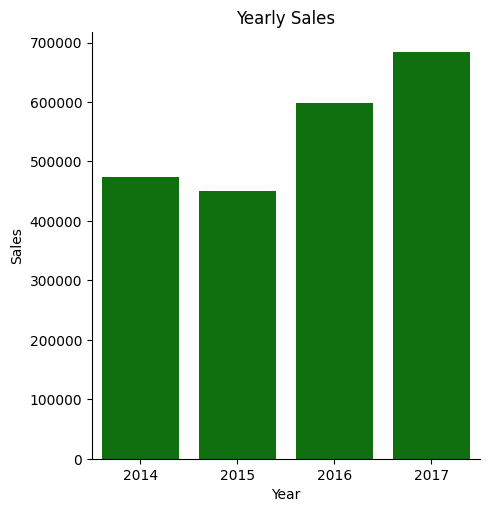

In [ ]:
sns.catplot(yearly_sales, x='Year', y='Sales', kind='bar', color='g', errorbar=None)
plt.title('Yearly Sales')
plt.show()

### Yearly Orders

In [ ]:
yearly_orders = success_orders.groupby('Year', as_index=False).agg(Orders=('Order ID', 'nunique'))
yearly_orders['%YoY change'] = yearly_orders['Orders'].pct_change().map('{:.2%}'.format)
yearly_orders

,Year,Orders,%YoY change
0,2014,916,nan%
1,2015,977,6.66%
2,2016,1238,26.71%
3,2017,1582,27.79%


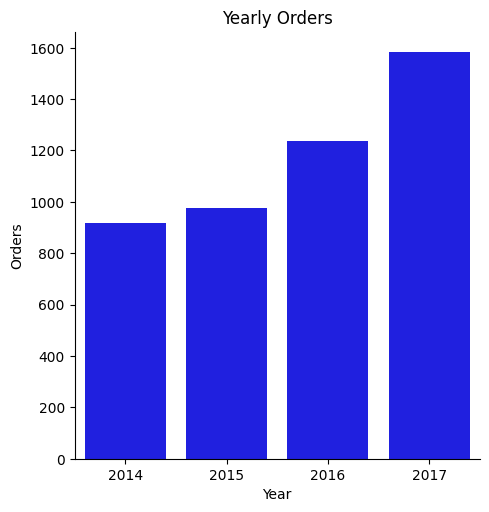

In [ ]:
sns.catplot(yearly_orders, x='Year', y='Orders', kind='bar', color='b', errorbar=None)
plt.title('Yearly Orders')
plt.show()

### Customers share by Segment

In [ ]:
# Tạo color palette
color1 = sns.color_palette('RdYlGn', 11)
color2 = sns.color_palette('GnBu', 11)

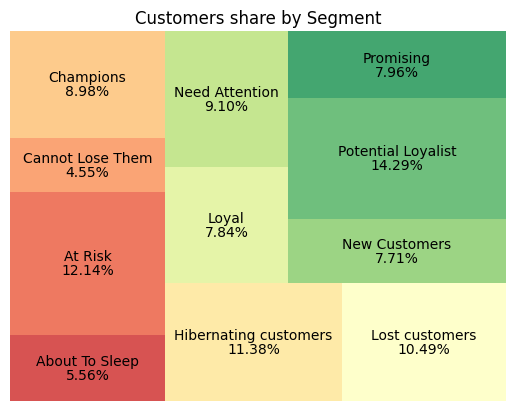

In [ ]:
squarify.plot(sizes=segment_data['Number of Customers'], value=(segment_data['Number of Customers'] / segment_data['Number of Customers'].sum()).map("{:.2%}".format), \
              label=segment_data['Segment'], alpha=0.8, color=color1)
plt.title('Customers share by Segment')
plt.axis('off')
plt.show()

### Sales share by Segment

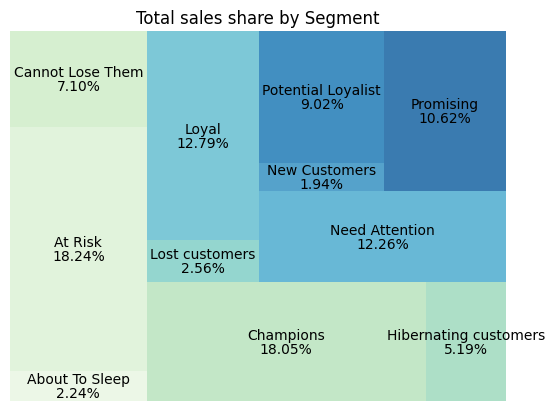

In [ ]:
squarify.plot(sizes=segment_data['Sales'], value=(segment_data['Sales'] / segment_data['Sales'].sum()).map("{:.2%}".format), \
              label=segment_data['Segment'], alpha=0.8, color=color2)
plt.title('Total sales share by Segment')
plt.axis('off')
plt.show()

### Average orders per customer by Segment

<Figure size 1000x800 with 0 Axes>

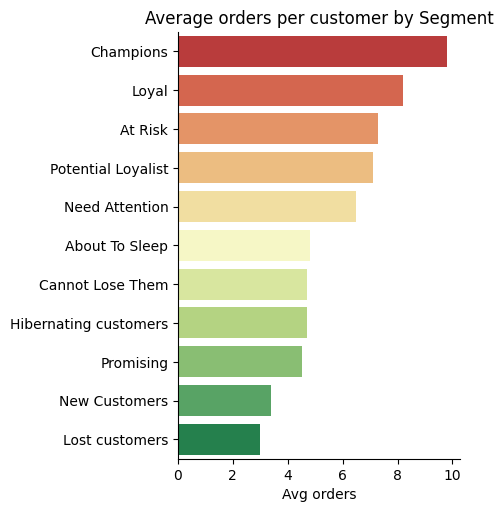

In [ ]:
plt.figure(figsize=(10, 8))
sns.catplot(segment_data,
            x='Avg orders',
            y='Segment',
            kind='bar',
            order=segment_data.sort_values('Avg orders', ascending=False)['Segment'],
            palette=color1)

plt.title('Average orders per customer by Segment')
plt.xlabel('Avg orders')
plt.ylabel(None)

plt.show()

### Average sales per customer by Segment

<Figure size 1000x800 with 0 Axes>

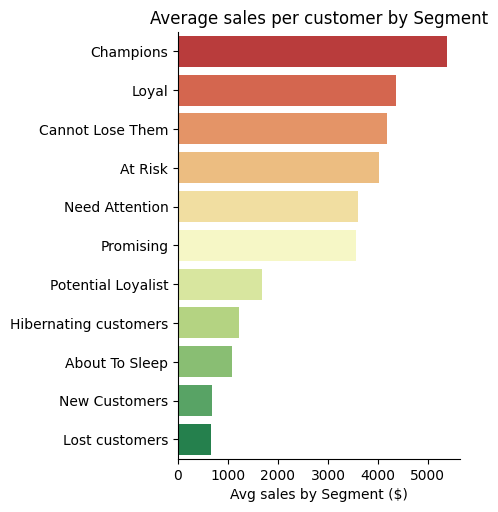

In [ ]:
plt.figure(figsize=(10, 8))
sns.catplot(segment_data,
            x='Avg sales',
            y='Segment',
            kind='bar',
            order=segment_data.sort_values('Avg sales', ascending=False)['Segment'],
            palette=color1)
plt.title('Average sales per customer by Segment')
plt.xlabel('Avg sales by Segment ($)')
plt.ylabel(None)
plt.show()

## 3.2. Phân tích Champions, Loyal và At Risk, Cannot Lose Them, Need Attention

### 3.2.1. Recency by Segment

<Figure size 600x400 with 0 Axes>

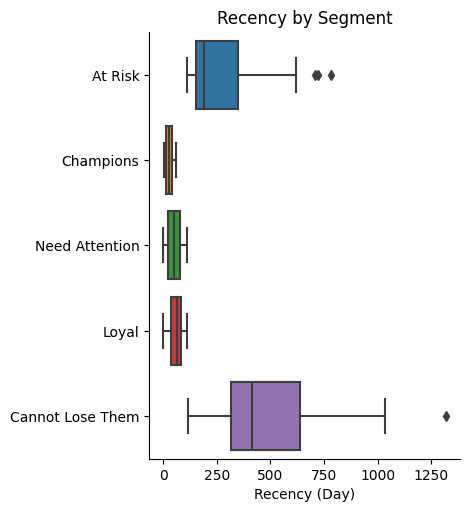

In [ ]:
plt.figure(figsize=(6, 4))
sns.catplot(rfm_segment[rfm_segment['Segment'].isin(['Champions', 'Loyal', 'At Risk', 'Cannot Lose Them', 'Need Attention'])], x='Recency', y='Segment', kind='box')
plt.title('Recency by Segment')
plt.xlabel('Recency (Day)')
plt.ylabel(None)
plt.show()

### 3.2.2. Ship Duration by Segment

<Figure size 600x400 with 0 Axes>

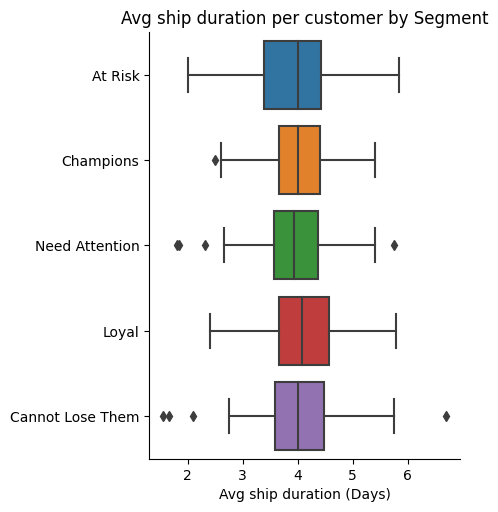

In [ ]:
plt.figure(figsize=(6, 4))
sns.catplot(rfm_segment[rfm_segment['Segment'].isin(['Champions', 'Loyal', 'At Risk', 'Cannot Lose Them', 'Need Attention'])], x='Avg Ship Duration', y='Segment', kind='box')
plt.title('Avg ship duration per customer by Segment')
plt.xlabel('Avg ship duration (Days)')
plt.ylabel(None)
plt.show()

### 3.2.3. Channel by Segment

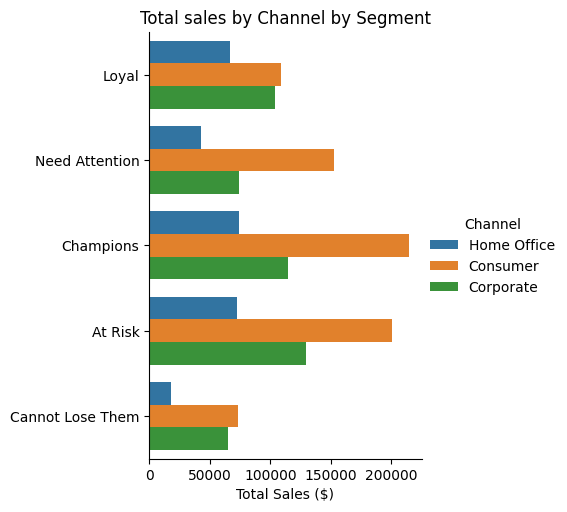

In [ ]:
segments = ['Champions', 'Loyal', 'At Risk', 'Cannot Lose Them', 'Need Attention']
sns.catplot(data=success_orders[success_orders['Segment'].isin(segments)], x='Sales', y='Segment', kind='bar', hue='Channel', estimator='sum', errorbar=None)
plt.title('Total sales by Channel by Segment')
plt.xlabel('Total Sales ($)')
plt.ylabel(None)
plt.show()

### 3.2.4. Product Category by Segment

In [ ]:
group_by_prod_segment = success_orders[success_orders['Segment'].isin(segments)].groupby(['Segment', 'Category'], as_index=False).agg(Orders=('Order ID', 'nunique'), Sales=('Sales', 'sum'))
group_by_prod_segment['Sales'] = group_by_prod_segment['Sales'].round(1)
group_by_prod_segment

,Segment,Category,Orders,Sales
0,At Risk,Furniture,261,120633.3
1,At Risk,Office Supplies,511,125042.2
2,At Risk,Technology,230,157075.7
3,Cannot Lose Them,Furniture,71,52780.3
4,Cannot Lose Them,Office Supplies,125,44995.5
5,Cannot Lose Them,Technology,55,59010.7
6,Champions,Furniture,241,130737.8
7,Champions,Office Supplies,516,140825.5
8,Champions,Technology,227,132161.3
9,Loyal,Furniture,188,91681.9


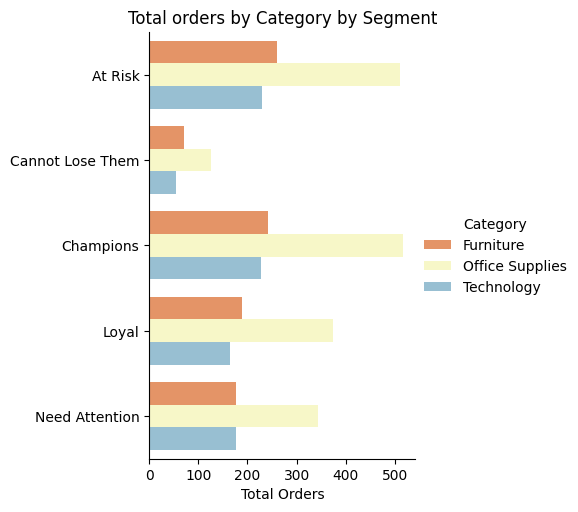

In [ ]:
#Dựng biểu đồ số lượng orders theo Category và Segment dựa theo bảng trên
sns.catplot(data=group_by_prod_segment, x='Orders', y='Segment', kind='bar', hue='Category', palette='RdYlBu', errorbar=None)
plt.title('Total orders by Category by Segment')
plt.xlabel('Total Orders')
plt.ylabel(None)
plt.show()

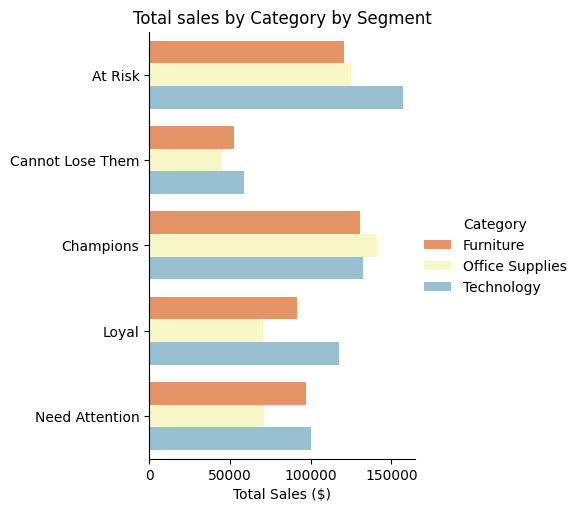

In [ ]:
#Dựng biểu đồ doanh thu theo Category và Segment dựa theo bảng trên
sns.catplot(data=group_by_prod_segment, x='Sales', y='Segment', kind='bar', hue='Category', palette='RdYlBu', estimator='sum', errorbar=None)
plt.title('Total sales by Category by Segment')
plt.xlabel('Total Sales ($)')
plt.ylabel(None)
plt.show()

### 3.2.5. Returned Orders by Segment

#### Returned rate by Segment

In [ ]:
return_by_segment = orders_returns[orders_returns['Segment'].isin(segments)].groupby(['Segment', 'Returned'], as_index=False).agg({'Order ID': 'nunique'})
return_by_segment.rename(columns={'Order ID': 'Orders'}, inplace=True)
return_by_segment['% Share'] = (100 * return_by_segment['Orders'] / return_by_segment.groupby('Segment')['Orders'].transform('sum')).round(2)
return_by_segment[['Segment', '% Share']][return_by_segment['Returned'] == 'Yes'].sort_values('% Share', ascending=False)

,Segment,% Share
3,Cannot Lose Them,10.58
1,At Risk,5.81
9,Need Attention,4.47
7,Loyal,3.62
5,Champions,2.51


#### Percentage of customers that had the last order returned by Segment

In [ ]:
#Tạo bảng tính ngày order gần đây nhất của từng khách hàng
latest_order_date_by_customer = orders_returns[orders_returns['Segment'].isin(segments)].groupby('Customer ID', as_index=False).agg({'Order Date': 'max'})

#Merge với bảng orders_returns trước đó để lấy thông tin Order ID, Returned, Segment
df = latest_order_date_by_customer.merge(orders_returns, on=['Customer ID', 'Order Date'], how='left')

#Tạo bảng đếm số orders theo segment và returned
df2 = df.groupby(['Segment', 'Returned'], as_index=False).agg(Orders=('Order ID', 'nunique'))
df2['%'] = (100 * df2['Orders'] / df2.groupby('Segment')['Orders'].transform('sum')).round(2) #Tính phần trăm
df2[['Segment', '%']][df2['Returned'] == 'Yes'].sort_values('%', ascending=False)

,Segment,%
3,Cannot Lose Them,22.22
1,At Risk,9.28
7,Loyal,4.84
5,Champions,2.82
9,Need Attention,2.78
